In [9]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
import matplotlib.pyplot as plt

In [2]:
seed=24
batch_size=  32

img_data_gen_args = dict(
                      rescale = 1/255.,
                         #rotation_range=90,
                      #width_shift_range=0.3,
                      #height_shift_range=0.3,
                      #shear_range=0.5,
                      #zoom_range=0.3,
                      #horizontal_flip=True,
                      #vertical_flip=True,
                      #fill_mode='reflect'
                         )

image_data_generator = ImageDataGenerator(**img_data_gen_args)


In [50]:
train_image_generator = image_data_generator.flow_from_directory("/Users/simoneboesso/Desktop/Modelling_videos/RealTime_FaceEmotionRecognition/Fer_2013/train",
                                                           seed=seed,
                                                           target_size=(224, 224), # for the target size (transfer learning)
                                                           batch_size=batch_size,
                                                           interpolation = "lanczos",
                                                           color_mode = "rgb",
                                                           class_mode="categorical")

Found 28709 images belonging to 7 classes.


In [51]:
test_image_generator = image_data_generator.flow_from_directory("/Users/simoneboesso/Desktop/Modelling_videos/RealTime_FaceEmotionRecognition/Fer_2013/test",
                                                           seed=seed,
                                                           target_size=(224, 224), # for the target size (transfer learning)
                                                           batch_size=batch_size,
                                                           interpolation = "lanczos",
                                                           color_mode = "rgb",
                                                           class_mode="categorical")

Found 7178 images belonging to 7 classes.


In [42]:
train_image_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

(224, 224, 3)


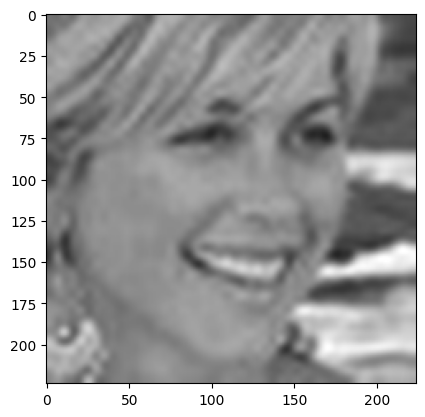

3


In [55]:
x,y = train_image_generator.next()
print(x[0].shape)
plt.imshow(x[0])
plt.show()
print(y[0].argmax())

In [58]:
y.shape

(32, 7)

In [59]:
x.shape

(32, 224, 224, 3)

# Transfer Learning for classification

In [24]:
import tensorflow as tf
from tensorflow.keras import layers

In [19]:
model = tf.keras.applications.MobileNetV2()
model.summary()

14536120/14536120 [==============================] - 3s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (R

In [20]:
base_input = model.layers[0].input

In [22]:
base_output = model.layers[-2].output

In [23]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [45]:
Emotion_output = layers.Dense(128, activation = 'relu')(base_output)
Emotion_output = layers.Dense(64, activation = 'relu')(Emotion_output)
Emotion_output = layers.Dense(7, activation = "softmax")(Emotion_output)

In [61]:
final_model = tf.keras.Model(inputs = base_input, outputs = Emotion_output)
final_model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [62]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [63]:
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.keras', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'), checkpointer ]

In [ ]:
history = final_model.fit(train_image_generator,validation_data=test_image_generator,
                    epochs=50, verbose= 1, callbacks=callbacks)


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()